#### **Project Title:**  ***"Pneumonia Detection from Chest X-Rays"***
##### **Dataset:** *"Chest X-Ray Images Dataset"*
##### **Step 01:** Loading Important Libraries

In [ ]:
#Importing the required libraries
import kagglehub  #For downloading the dataset.
import os  #For directory and file operations.
#TensorFlow and Keras for building and training the model.
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  #For data augmentation.
from tensorflow.keras.models import Sequential, Model  #For building CNN and transfer learning models.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam  #Optimizer for model training.
#For histogram equalization and preprocessing.
import cv2  
#For numerical operations.
import numpy as np  
#Scikit-learn for evaluation metrics.
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve  
#Matplotlib for plotting.
import matplotlib.pyplot as plt  #For visualization of metrics and ROC curves.

##### **Step 02:** Loading the Dataset

In [2]:
#Downloading the latest version of the Chest X-Ray Pneumonia dataset using KaggleHub.
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
#Printing the path where the dataset has been downloaded.
print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:22<00:00, 109MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


##### **Step 03:** Data Preprocessing

In [3]:
#The dataset path where KaggleHub has downloaded the Chest X-Ray Pneumonia dataset.
path = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2"
#Defining dataset directories for training, validation and testing data.
train_dir = os.path.join(path, "chest_xray", "train")  #Path to training data.
val_dir = os.path.join(path, "chest_xray", "val")      #Path to validation data.
test_dir = os.path.join(path, "chest_xray", "test")    #Path to testing data.
#Data generator for training data with augmentation and normalization.
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  #Normalizing pixel values to the range [0, 1].
    rotation_range=20,  #Applying random rotations within a range of 20 degrees.
    width_shift_range=0.2,  #Applying random horizontal shifts (20% of the width).
    height_shift_range=0.2,  #Applying random vertical shifts (20% of the height).
    shear_range=0.2,  #Applying random shearing transformations.
    zoom_range=0.2,  #Applying random zoom.
    horizontal_flip=True,  #Applying random horizontal flips.
)
#Data generator for validation and test data with only normalization.
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
#Batch size used for loading data in smaller chunks to save memory.
batch_size = 32  
#Generator for training data.
train_generator = train_datagen.flow_from_directory(
    train_dir,  #Directory containing training images.
    target_size=(224, 224),  #Resize images to 224x224 pixels.
    batch_size=batch_size,  #Number of images per batch.
    class_mode="binary",  #Binary classification: NORMAL (0) or PNEUMONIA (1).
)
#Generator for validation data.
val_generator = val_test_datagen.flow_from_directory(
    val_dir,  #Directory containing validation images.
    target_size=(224, 224),  #Resize images to 224x224 pixels.
    batch_size=batch_size,  #Number of images per batch.
    class_mode="binary",  #Binary classification: NORMAL (0) or PNEUMONIA (1).
)
#Generator for test data.
test_generator = val_test_datagen.flow_from_directory(
    test_dir,  #Directory containing test images.
    target_size=(224, 224),  #Resize images to 224x224 pixels.
    batch_size=batch_size,  #Number of images per batch.
    class_mode="binary",  #Binary classification: NORMAL (0) or PNEUMONIA (1).
)
#Printing the class labels and the number of samples in each generator.
print(f"Classes: {train_generator.class_indices}")  #Mapping of class names to labels.
print(f"Training samples: {train_generator.samples}") #Number of training samples.
print(f"Validation samples: {val_generator.samples}")  #Number of validation samples.
print(f"Testing samples: {test_generator.samples}")  #Number of testing samples.

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}
Training samples: 5216
Validation samples: 16
Testing samples: 624


##### **Step 04:** Data Augmentation

Found 5216 images belonging to 2 classes.


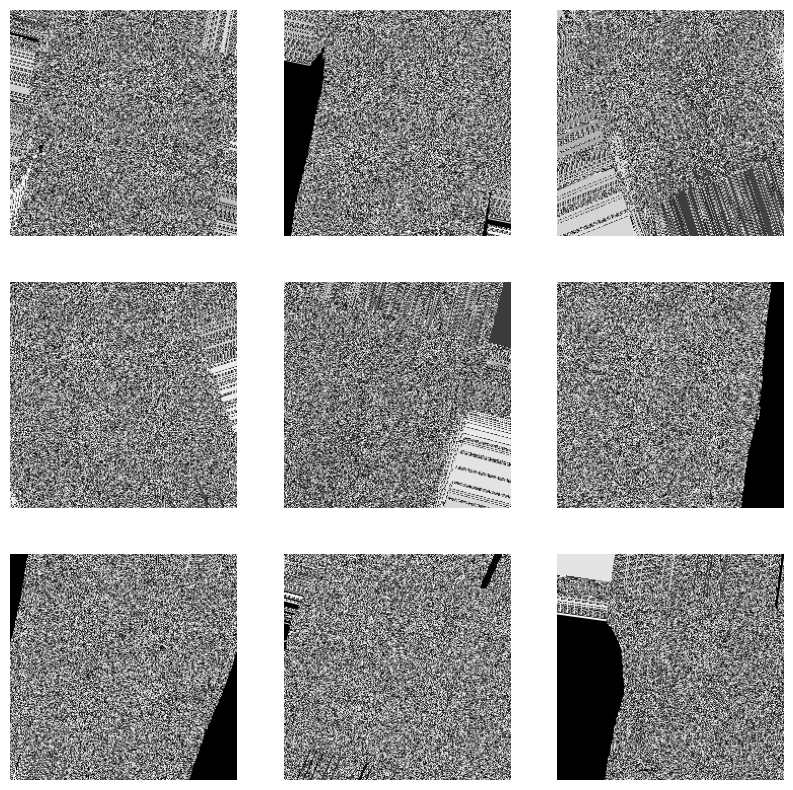

In [4]:
#Defining a custom preprocessing function for histogram equalization.
def preprocess_histogram(img):
    #Converting the image to YUV color space.
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    #Applying histogram equalization only to the Y channel.
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    #Converting the image back to RGB color space.
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    #Converting image to float32 to ensure compatibility with ImageDataGenerator.
    return img.astype(np.float32)
#Creating an ImageDataGenerator for data augmentation.
data_augmentation = ImageDataGenerator(
    rescale=1.0 / 255.0,  #Normalizing pixel values.
    rotation_range=20,  #Random rotation within 20 degrees.
    width_shift_range=0.2,  #Random horizontal shift.
    height_shift_range=0.2,  #Random vertical shift.
    shear_range=0.15,  #Shearing transformation.
    zoom_range=0.2,  #Random zoom.
    horizontal_flip=True,  #Random horizontal flip.
    preprocessing_function=lambda img: preprocess_histogram((img * 255).astype(np.uint8))  #Applying histogram equalization.
)
#Loading and augmenting images from a directory.
train_dir = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train"
#Creating a generator for training images.
train_generator = data_augmentation.flow_from_directory(
    train_dir,
    target_size=(224, 224),  #Resize images to 224x224.
    batch_size=32,  #Batch size.
    class_mode="binary",  #Binary classification (Pneumonia/Normal).
)
#Function to visualize augmented images.
def visualize_augmentation(generator):
    import matplotlib.pyplot as plt
    #Get a batch of augmented images.
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):  #Displaying 9 images.
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])  #No need to rescale as ImageDataGenerator has already rescaled it.
        plt.axis("off")
    plt.show()
#Visualizing some augmented images.
visualize_augmentation(train_generator)

##### **Step 05:** Model Development

In [13]:
#CNN Architecture.
#Defining a CNN architecture for binary classification.
def build_cnn(input_shape=(224, 224, 3)):
    model = Sequential([  #Sequential model to stack layers linearly.
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  #First convolutional layer with 32 filters and 3x3 kernel.
        MaxPooling2D((2, 2)),  #Max pooling to reduce spatial dimensions.
        Conv2D(64, (3, 3), activation='relu'),  #Second convolutional layer with 64 filters.
        MaxPooling2D((2, 2)),  #Max pooling to reduce spatial dimensions further.
        Conv2D(128, (3, 3), activation='relu'),  #Third convolutional layer with 128 filters.
        MaxPooling2D((2, 2)),  #Max pooling to reduce spatial dimensions further.
        Flatten(),  #Flatten the 3D feature maps into a 1D vector for the dense layers.
        Dense(128, activation='relu'),  #Fully connected dense layer with 128 neurons.
        Dropout(0.5),  #Dropout layer for regularization to prevent overfitting.
        Dense(1, activation='sigmoid')  #Output layer with sigmoid activation for binary classification.
    ])
    return model  #Returning the compiled model.
#Building and compiling the CNN model.
cnn_model = build_cnn()  #Initializing the CNN model.
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),  #Adam optimizer with a learning rate of 0.001.
    loss='binary_crossentropy',  #Loss function for binary classification.
    metrics=['accuracy']  #Metric to monitor accuracy during training.
)
#Displaying the architecture of the model.
cnn_model.summary()  

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#Fine-Tuning a Pre-Trained Model (MobileNetV2).
#Loading and fine-tuning MobileNetV2.
def build_finetuned_model(input_shape=(224, 224, 3), num_classes=2):
    # Load the MobileNetV2 model pre-trained on ImageNet, excluding the top classification layers.
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  #Freeze the base model layers to retain pre-trained features during initial training.
    #Adding custom classification layers for pneumonia detection.
    inputs = Input(shape=input_shape)  #Input layer matching the shape of the input data.
    x = base_model(inputs, training=False)  #Pass inputs through the pre-trained MobileNetV2 base model.
    x = GlobalAveragePooling2D()(x)  #Pool the features globally to reduce dimensionality.
    x = Dense(128, activation='relu')(x)  #Add a dense layer with 128 neurons and ReLU activation.
    x = Dropout(0.5)(x)  #Add dropout to reduce overfitting.
    outputs = Dense(num_classes, activation='softmax')(x)  #Output layer with softmax activation for multi-class classification.
    model = Model(inputs, outputs)  #Combine the custom layers with the base model to create the final model.
    return model  #Returning the constructed model.
#Building and compiling the fine-tuned model.
finetuned_model = build_finetuned_model()  #Initializing the fine-tuned model.
finetuned_model.compile(
    optimizer=Adam(learning_rate=0.001),  #Adam optimizer with a learning rate of 0.001.
    loss='categorical_crossentropy',  #Loss function for multi-class classification.
    metrics=['accuracy']  #Metric to monitor accuracy during training.
)
#Displaying the architecture of the fine-tuned model.
finetuned_model.summary()  

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
#Training the model using data generators,
history = cnn_model.fit(
    train_generator,  #Training data generator that provides batches of augmented training data.
    validation_data=val_generator,  #Validation data generator that provides validation data for performance monitoring.
    epochs=10,  #Number of training epochs; each epoch represents one pass through the entire training dataset.
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  #Number of batches per epoch for training.
    validation_steps=val_generator.samples // val_generator.batch_size,  #Number of batches per epoch for validation.
    verbose=1  # Verbosity mode; 1 prints progress bars and epoch information.
)
#Saving the trained model to a file.
cnn_model.save('cnn_pneumonia_model.h5')  #Saves the trained model in HDF5 format for future use.

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 694s 4s/step - accuracy: 0.7432 - loss: 0.8544 - val_accuracy: 0.5625 - val_loss: 0.6739
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 0.6739
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 704s 4s/step - accuracy: 0.8292 - loss: 0.3872 - val_accuracy: 0.6875 - val_loss: 0.6366
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_loss: 0.6366
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 698s 4s/step - accuracy: 0.8480 - loss: 0.3531 - val_accuracy: 0.6250 - val_loss: 0.6410
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.6410
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 695s 4s/step - accuracy: 0.8437 - loss: 0.3628 - val_accuracy: 0.7500 - val_loss: 0.6139
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.6139
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 692s 4s/step - accuracy: 0.8453 - loss: 

##### **Step 06:** Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
Sensitivity: 0.52
Specificity: 0.50
ROC-AUC Score: 0.50


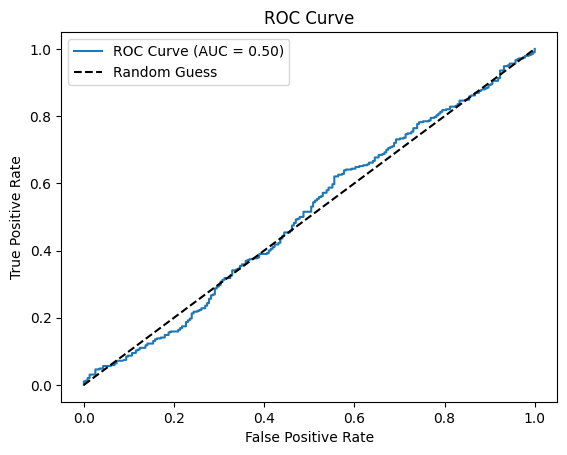

In [16]:
#Using metrics like sensitivity, specificity and ROC-AUC score.
#Getting predictions on the test dataset.
y_pred_probs = cnn_model.predict(test_generator)  #Predict probabilities.
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()  #Convert to binary predictions.
y_true = test_generator.classes  #True labels from the test generator.
#Computing confusion matrix.
conf_matrix = confusion_matrix(y_true, y_pred_classes)
tn, fp, fn, tp = conf_matrix.ravel()
#Calculating sensitivity, specificity and ROC-AUC.
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
#Plotting ROC Curve.
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step
Augmented - Sensitivity: 0.92
Augmented - Specificity: 0.07
Augmented - ROC-AUC Score: 0.50


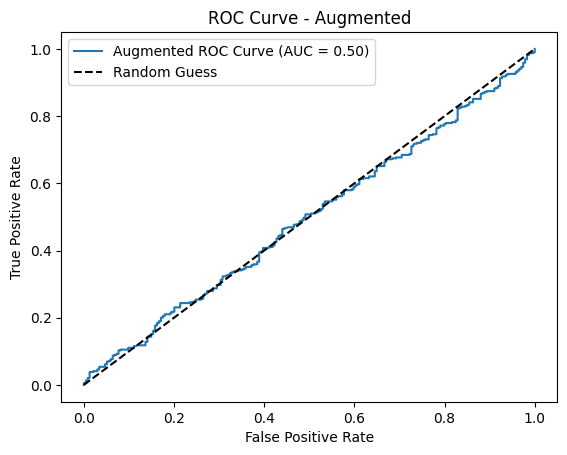

Found 5216 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 643s 4s/step - accuracy: 0.9117 - loss: 0.2331 - val_accuracy: 0.7500 - val_loss: 0.7651
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.7651
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 637s 4s/step - accuracy: 0.9546 - loss: 0.1172 - val_accuracy: 0.8125 - val_loss: 0.4557
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.4557
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 668s 4s/step - accuracy: 0.9672 - loss: 0.0852 - val_accuracy: 0.7500 - val_loss: 0.8044
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.8044
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 630s 4s/step - accuracy: 0.9654 - loss: 0.0823 - val_accuracy: 0.8750 - val_loss: 0.3639
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.3639
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 683s 4s/step - accuracy: 0.9774 - loss: 

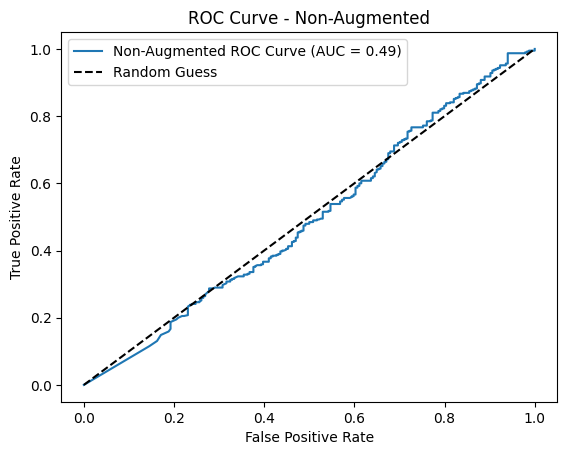


Comparison of Augmented vs. Non-Augmented Results:
Augmented - Sensitivity: 0.92, Specificity: 0.07, ROC-AUC: 0.50
Non-Augmented - Sensitivity: 0.88, Specificity: 0.14, ROC-AUC: 0.49


In [18]:
#Comparing results on augmented vs. non-augmented datasets.
#Evaluating the model trained on the augmented dataset.
#Generating predictions on the test dataset.
y_pred_probs = cnn_model.predict(test_generator)  #Predicting probabilities for the test set.
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()  #Converting probabilities to binary class predictions.
y_true = test_generator.classes  #True labels from the test generator.
#Computing metrics for the augmented model.
conf_matrix = confusion_matrix(y_true, y_pred_classes)  #Compute the confusion matrix.
tn, fp, fn, tp = conf_matrix.ravel()  #Extract true negatives (tn), false positives (fp), false negatives (fn), and true positives (tp).
sensitivity = tp / (tp + fn)  #Calculate sensitivity (recall).
specificity = tn / (tn + fp)  #Calculate specificity.
roc_auc = roc_auc_score(y_true, y_pred_probs)  #Compute the ROC-AUC score.
#Printing evaluation metrics for the augmented model.
print(f"Augmented - Sensitivity: {sensitivity:.2f}")
print(f"Augmented - Specificity: {specificity:.2f}")
print(f"Augmented - ROC-AUC Score: {roc_auc:.2f}")
#Plotting the ROC Curve for the augmented model.
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)  #Calculate false positive and true positive rates.
plt.figure()
plt.plot(fpr, tpr, label=f'Augmented ROC Curve (AUC = {roc_auc:.2f})')  #Plot ROC curve.
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  #Add a random guess line.
plt.xlabel('False Positive Rate')  #Label for X-axis.
plt.ylabel('True Positive Rate')  #Label for Y-axis.
plt.title('ROC Curve - Augmented')  #Title of the plot.
plt.legend()  #Add legend.
plt.show()
#Training the model on non-augmented data.
#Creating a data generator for non-augmented training data (only normalization).
non_augmented_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  #Normalize pixel values.
train_generator_no_aug = non_augmented_datagen.flow_from_directory(
    train_dir,  #Path to training data.
    target_size=(224, 224),  #Resize images to 224x224 pixels.
    batch_size=32,  #Batch size.
    class_mode="binary"  #Binary classification.
)
#Re-compiling the model to reset weights for non-augmented training.
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),  #Adam optimizer.
    loss='binary_crossentropy',  #Binary crossentropy loss for binary classification.
    metrics=['accuracy']  #Monitor accuracy during training.
)
#Training the model using non-augmented data.
history_no_aug = cnn_model.fit(
    train_generator_no_aug,  #Training data generator without augmentation.
    validation_data=val_generator,  #Validation data generator.
    epochs=10,  #Number of epochs.
    steps_per_epoch=train_generator_no_aug.samples // train_generator_no_aug.batch_size,  #Training steps per epoch.
    validation_steps=val_generator.samples // val_generator.batch_size,  #Validation steps per epoch.
    verbose=1  #Verbosity mode for detailed progress output.
)
#Evaluating the non-augmented dataset model.
#Generating predictions on the test dataset.
y_pred_probs_no_aug = cnn_model.predict(test_generator)  #Predicting probabilities for the test set.
y_pred_classes_no_aug = (y_pred_probs_no_aug > 0.5).astype(int).flatten()  #Converting probabilities to binary class predictions.
#Computing metrics for the non-augmented model.
conf_matrix_no_aug = confusion_matrix(y_true, y_pred_classes_no_aug)  #Compute confusion matrix.
tn_no_aug, fp_no_aug, fn_no_aug, tp_no_aug = conf_matrix_no_aug.ravel()  #Extract confusion matrix elements.
sensitivity_no_aug = tp_no_aug / (tp_no_aug + fn_no_aug)  #Calculate sensitivity (recall).
specificity_no_aug = tn_no_aug / (tn_no_aug + fp_no_aug)  #Calculate specificity.
roc_auc_no_aug = roc_auc_score(y_true, y_pred_probs_no_aug)  #Compute the ROC-AUC score.
#Printing evaluation metrics for the non-augmented model.
print(f"Non-Augmented - Sensitivity: {sensitivity_no_aug:.2f}")
print(f"Non-Augmented - Specificity: {specificity_no_aug:.2f}")
print(f"Non-Augmented - ROC-AUC Score: {roc_auc_no_aug:.2f}")
#Plotting the ROC Curve for the non-augmented model.
fpr_no_aug, tpr_no_aug, _ = roc_curve(y_true, y_pred_probs_no_aug)  #Calculate false positive and true positive rates.
plt.figure()
plt.plot(fpr_no_aug, tpr_no_aug, label=f'Non-Augmented ROC Curve (AUC = {roc_auc_no_aug:.2f})')  #Plot ROC curve.
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  #Add a random guess line.
plt.xlabel('False Positive Rate')  #Label for X-axis.
plt.ylabel('True Positive Rate')  #Label for Y-axis.
plt.title('ROC Curve - Non-Augmented')  #Title of the plot.
plt.legend()  #Add legend.
plt.show()
#Comparing results.
#Printing a side-by-side comparison of augmented vs. non-augmented results.
print("\nComparison of Augmented vs. Non-Augmented Results:")
print(f"Augmented - Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, ROC-AUC: {roc_auc:.2f}")
print(f"Non-Augmented - Sensitivity: {sensitivity_no_aug:.2f}, Specificity: {specificity_no_aug:.2f}, ROC-AUC: {roc_auc_no_aug:.2f}")

##### **Conclusion on Model Performance and Challenges**

##### **Model Performance**
1. **Augmented Dataset**:
   - **Sensitivity**: 92% (high pneumonia detection).
   - **Specificity**: 7% (poor normal case detection).
   - **ROC-AUC**: 0.50 (random-level performance).

2. **Non-Augmented Dataset**:
   - **Sensitivity**: 88% (slightly lower pneumonia detection).
   - **Specificity**: 14% (slightly better normal case detection).
   - **ROC-AUC**: 0.49 (poor overall discrimination).

3. **Comparison**:
   - Augmented dataset improved sensitivity but severely hurt specificity.
   - Both models showed low ROC-AUC scores, indicating poor differentiation between classes.

##### **Challenges**
- **Class Imbalance**: Caused bias toward the majority class (pneumonia).
- **Small Validation Set**: Only 16 samples, leading to unreliable validation metrics.
- **Model Complexity**: Overfitting due to high parameter count in the CNN architecture.
- **Training Instability**: Interruptions due to misconfigured data generator.
- **Augmentation Noise**: Excessive variability reduced the model's specificity.
Both models showed potential for detecting pneumonia but need improvements to handle imbalanced data and optimize specificity for reliable performance.
***